In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
from scipy.stats import beta
import pandas as pd
import pymc3 as pm

from dask.distributed import Client, LocalCluster
import dask.delayed

import logging

# Session conversion dependent on SPU

In [134]:
num_users = 100000
# num_users = 5000

sessions_per_user = np.random.geometric(0.1, size=num_users)
avg_conversion_rate = 0.2
rates = avg_conversion_rate*1/5 + avg_conversion_rate*4/5*np.exp(-0.1*(sessions_per_user - 1))
a = rates*1000
b = 1000 - rates*1000
conversion_rates = np.random.beta(a, b, size=num_users);

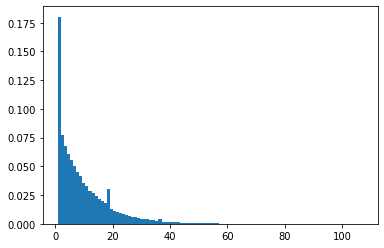

In [135]:
plt.hist(sessions_per_user, density=True, bins=100);

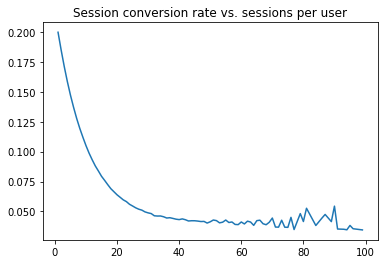

In [136]:
df = pd.DataFrame({'spu': sessions_per_user, 'cv': conversion_rates})
gdf = df.groupby('spu').cv.mean().reset_index(name='mean_cv')

plt.title('Session conversion rate vs. sessions per user');
# plt.plot(gdf[gdf.spu <= 10].spu, gdf[gdf.spu <= 10].mean_cv);
plt.plot(gdf[gdf.spu <= 100].spu, gdf[gdf.spu <= 100].mean_cv);

In [137]:
data = {
    'user': [],
    'session_id': [],
    'session_converted': []
}

for user_id, num_sessions in enumerate(sessions_per_user):
    conversion_rate = conversion_rates[user_id]
    for session_id in range(1, num_sessions+1):
        session_converted = np.random.choice([0, 1], p=[1-conversion_rate, conversion_rate])
        data['user'].append(user_id)
        data['session_id'].append(f"{user_id}-{session_id}")
        data['session_converted'].append(session_converted)

In [138]:
df = pd.DataFrame(data)
df.shape

(1000069, 3)

In [139]:
udf = (
    df
    .groupby('user')
    .agg(
        total_sessions=('session_converted', 'count'),
        num_converted=('session_converted', 'sum'),
    ).reset_index()
)
print(f"Avg SPU: {udf.total_sessions.mean()}")
udf.shape

Avg SPU: 10.00069


(100000, 3)

In [27]:
cluster = LocalCluster(
    n_workers=12, 
    threads_per_worker=1, 
    processes=True, 
    silence_logs=logging.ERROR
)
client = Client(cluster)
client

# client = Client('tcp://127.0.0.1:57092')
# client

# client.shutdown()
# client.close()

Client Scheduler: tcp://127.0.0.1:61906 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 34.36 GB


In [146]:
client.restart()

Client Scheduler: tcp://127.0.0.1:61906 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 11 Cores: 11 Memory: 31.50 GB


In [147]:
# 1) randomly select 10,000 users, calculate session conversion rate
# 2) repeat 10,000 times

def simulate_user_randomization(scattered_udf):
    res = []
    for x in range(0, 500):
        sampled_users = scattered_udf.sample(10000, replace=True)
        total_sessions = sampled_users['total_sessions'].sum()
        total_converted = sampled_users['num_converted'].sum()
        res.append({
            'total_sessions': total_sessions, 
            'session_conversion_rate': total_converted/total_sessions
        })
    return res

scattered_udf = client.scatter(udf)
delayed_user_randomization_results = []
for x in range(0, 100):
    result = dask.delayed(simulate_user_randomization)(scattered_udf)
    delayed_user_randomization_results.append(result)

user_randomization_results = dask.compute(*delayed_user_randomization_results)
user_randomization_results = list(itertools.chain.from_iterable(user_randomization_results))

In [148]:
print(np.mean([x['session_conversion_rate'] for x in user_randomization_results]))
print(np.mean([x['total_sessions'] for x in user_randomization_results]))

0.0863443420400332
100004.80278


In [149]:
# see how many sessions you got, on average, in :point-up:
# 1) randomly select X sessions, calculate session conversion rate
# 2) repeat 10,000 times
avg_num_sessions = int(np.mean([x['total_sessions'] for x in user_randomization_results]))
# print(avg_num_sessions)

def simulate_session_randomization(scattered_df):
    res = []
    for x in range(0, 500):
        sampled_sessions = scattered_df.sample(avg_num_sessions, replace=True)
        total_sessions = sampled_sessions['session_converted'].count()
        total_converted = sampled_sessions['session_converted'].sum()    
        res.append(total_converted/total_sessions)
    return res

scattered_df = client.scatter(df)
delayed_session_randomization_results = []
for x in range(0, 100):
    result = dask.delayed(simulate_session_randomization)(scattered_df)
    delayed_session_randomization_results.append(result)

session_randomization_results = dask.compute(*delayed_session_randomization_results)
session_randomization_results = list(itertools.chain.from_iterable(session_randomization_results))

In [150]:
print(np.mean([x for x in session_randomization_results]))

0.08634213091476342


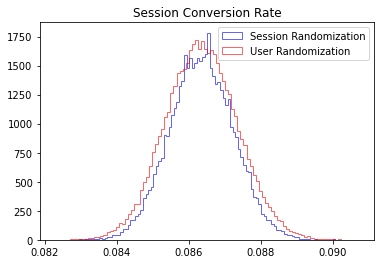

In [151]:
sl = [x for x in session_randomization_results]
ul = [x['session_conversion_rate'] for x in user_randomization_results]

plt.title('Session Conversion Rate')
plt.hist(sl, bins=100, alpha=0.6, color='b', label='Session Randomization', histtype='step');
plt.hist(ul, bins=100, alpha=0.6, color='r', label='User Randomization', histtype='step');
plt.legend();